# Final Report - Regression Project

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest, RFE
import os
import warnings
warnings.filterwarnings('ignore')
import math
from acquire import acquire_zillow
from prepare import prep_data
from prepare import split_data
from prepare import remove_outliers
from prepare import split_by_region

In [2]:
#pull the dataset from the database using the acquire_zillow function in the acquire.py file
df = acquire_zillow()
#since we are only loosing 112 rows out of 53442 if we drop all the rows with null values, that is the approach I took
df = prep_data(df)
#split the data into train, validate, and test using the split_data function from the prepare.py file
train, validate, test = split_data(df)
#assign the columns we want to remove outliers from to a variable that can be used with the function
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
#use the function from the prepare.py file to remove outliers from the train dataset
train = remove_outliers(train, 1.5, out_columns)

Reading from csv file...


In [3]:
train.shape

(26695, 6)

---

### Explore Variable Interactions with visualizations and Statistical Testing

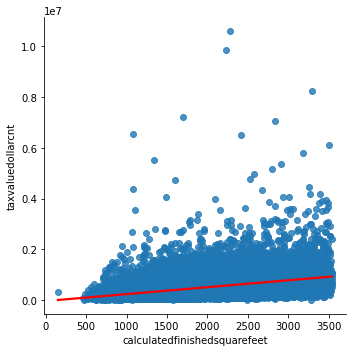

In [4]:
sns.lmplot(x='calculatedfinishedsquarefeet', y='taxvaluedollarcnt', data=train, line_kws={'color': 'red'})
plt.show()

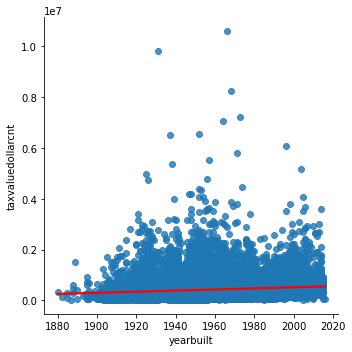

In [5]:
sns.lmplot(x='yearbuilt', y='taxvaluedollarcnt', data=train, line_kws={'color': 'red'})
plt.show()

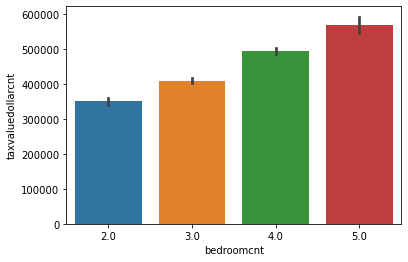

In [6]:
sns.barplot(x='bedroomcnt', y='taxvaluedollarcnt', data=train)
plt.show()

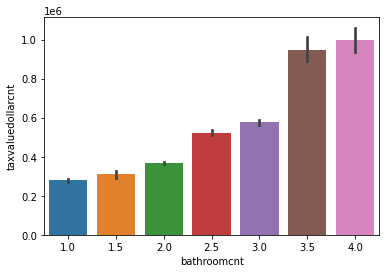

In [7]:
sns.barplot(x='bathroomcnt', y='taxvaluedollarcnt', data=train)
plt.show()

---

In [8]:
x_train = train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_train = train[['taxvaluedollarcnt']]
x_validate = validate[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_validate = validate[['taxvaluedollarcnt']]

scaler = MinMaxScaler()
scaler.fit(x_train)
scaled_df = scaler.transform(x_train)
x_train_scaled = pd.DataFrame(scaled_df, columns=x_train.columns, index=x_train.index)
val_scaled_df = scaler.transform(x_validate)
x_validate_scaled = pd.DataFrame(val_scaled_df, columns=x_validate.columns, index=x_validate.index)


In [9]:
x_train_scaled.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt
8251,0.666667,0.333333,0.612522,0.654412
42134,0.333333,0.333333,0.510927,0.897059
44913,0.666667,0.333333,0.420260,0.669118
34101,0.666667,0.166667,0.516834,0.544118
19557,0.333333,0.333333,0.409333,0.779412


In [10]:
x_validate_scaled.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt
32004,0.000000,0.000000,0.197283,0.330882
44332,0.333333,0.333333,0.163024,0.433824
21552,0.333333,0.666667,0.579740,0.852941
21019,0.333333,0.333333,0.304489,0.536765
38671,0.333333,0.333333,0.322800,0.544118


In [11]:
x = x_train_scaled
y = y_train
model = LinearRegression()
rfe = RFE(model, n_features_to_select=1).fit(x, y)
pd.DataFrame({'rfe_ranking': rfe.ranking_}, index=x.columns)

,rfe_ranking
bedroomcnt,2
bathroomcnt,4
calculatedfinishedsquarefeet,1
yearbuilt,3


In [12]:
predictions = pd.DataFrame({'actual': validate.taxvaluedollarcnt})
predictions['baseline'] = validate.taxvaluedollarcnt.mean()

In [13]:
lm = LinearRegression()
lm.fit(x_train_scaled, y_train)
predictions['multiple_regression'] = lm.predict(x_validate_scaled)

In [14]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(x_train_scaled)
x_train_poly = pd.DataFrame(
    poly.transform(x_train_scaled),
    columns=poly.get_feature_names(x_train_scaled.columns),
    index=x_train_scaled.index,
)
poly_rm = LinearRegression()
poly_rm.fit(x_train_poly, y_train)

x_validate_poly = poly.transform(x_validate_scaled)
predictions['polynomial degree 2'] = poly_rm.predict(x_validate_poly)

In [15]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(x_train_scaled)
x_train_poly = pd.DataFrame(
    poly.transform(x_train_scaled),
    columns=poly.get_feature_names(x_train_scaled.columns),
    index=x_train_scaled.index,
)
lm = LinearRegression()
lm.fit(x_train_poly, y_train)

x_validate_poly = poly.transform(x_validate_scaled)
predictions['polynomial only interaction'] = lm.predict(x_validate_poly)

In [16]:
predictions.head()

,actual,baseline,multiple_regression,polynomial degree 2,polynomial only interaction
32004,23350.0,529502.685912,255942.263546,270132.472523,264225.822817
44332,246427.0,529502.685912,186441.231296,219493.657189,184258.353066
21552,638000.0,529502.685912,565690.697385,559928.659516,562760.081133
21019,117407.0,529502.685912,297389.589694,283092.332215,293372.569808
38671,73174.0,529502.685912,313562.183969,294293.314806,307893.907807


In [17]:
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse).apply(math.sqrt)

actual                              0.000000
baseline                       710711.727758
multiple_regression            580938.183527
polynomial degree 2            558677.387305
polynomial only interaction    550270.829353
dtype: float64

---

In [2]:
#pull the dataset from the database using the acquire_zillow function in the acquire.py file
df = acquire_zillow()
#since we are only loosing 112 rows out of 53442 if we drop all the rows with null values, that is the approach I took
df = prep_data(df)

df1, df2, df3 = split_by_region(df)
df1.shape, df2.shape, df3.shape

Reading from csv file...


((33880, 6), (14082, 6), (4358, 6))

In [4]:
#split the data into train, validate, and test using the split_data function from the prepare.py file
train, validate, test = split_data(df1)
#assign the columns we want to remove outliers from to a variable that can be used with the function
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
#use the function from the prepare.py file to remove outliers from the train dataset
train = remove_outliers(train, 1.5, out_columns)

In [6]:
train.shape, validate.shape, test.shape

((17266, 6), (8132, 6), (6776, 6))

In [7]:
x_train = train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_train = train[['taxvaluedollarcnt']]
x_validate = validate[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_validate = validate[['taxvaluedollarcnt']]

scaler = MinMaxScaler()
scaler.fit(x_train)
scaled_df = scaler.transform(x_train)
x_train_scaled = pd.DataFrame(scaled_df, columns=x_train.columns, index=x_train.index)
val_scaled_df = scaler.transform(x_validate)
x_validate_scaled = pd.DataFrame(val_scaled_df, columns=x_validate.columns, index=x_validate.index)

predictions = pd.DataFrame({'actual': validate.taxvaluedollarcnt})
predictions['baseline'] = validate.taxvaluedollarcnt.mean()

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(x_train_scaled)
x_train_poly = pd.DataFrame(
    poly.transform(x_train_scaled),
    columns=poly.get_feature_names(x_train_scaled.columns),
    index=x_train_scaled.index,
)
lm = LinearRegression()
lm.fit(x_train_poly, y_train)

x_validate_poly = poly.transform(x_validate_scaled)
predictions['polynomial only interaction'] = lm.predict(x_validate_poly)

def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse).apply(math.sqrt)

actual                              0.000000
baseline                       937994.726017
polynomial only interaction    589841.530967
dtype: float64